# In this notebook, I will replicate vision transformer and use it to classify different natural scenes.

The paper for the vision transformer is as follows: https://arxiv.org/abs/2010.11929

The dataset is from kaggle : https://www.kaggle.com/datasets/puneet6060/intel-image-classification?resource=download

## A data science project consists of the following steps:
1. Data Analysis
2. Feature Engineering
3. Building Model
4. Finetuning Model
5. Model Deployment

For the purpose of this expercise I will be working on the steps  1-4 and answer a few questions along the way.

Let's dive into the data and explore the fascinating world of computer vision!


In [15]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import os
import random
from PIL import Image

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [1]:
# Get helper functions for plotting
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/pusapatiakhilraju/Pytorch-Neural-Net-Classification/master/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Import accuracy metric
from helper_functions import accuracy_fn, download_data  # Note: could also use torchmetrics.Accuracy(task = 'multiclass')

# Data Setup

First I will read one of the images and see the shape and size of it

In [29]:
image_path = 'archive/'

for dirpath, dirnames, filenames in os.walk(image_path, topdown = True):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in 'archive/'.
There are 1 directories and 0 images in 'archive/seg_test'.
There are 6 directories and 0 images in 'archive/seg_test/seg_test'.
There are 0 directories and 474 images in 'archive/seg_test/seg_test/forest'.
There are 0 directories and 437 images in 'archive/seg_test/seg_test/buildings'.
There are 0 directories and 553 images in 'archive/seg_test/seg_test/glacier'.
There are 0 directories and 501 images in 'archive/seg_test/seg_test/street'.
There are 0 directories and 525 images in 'archive/seg_test/seg_test/mountain'.
There are 0 directories and 510 images in 'archive/seg_test/seg_test/sea'.
There are 1 directories and 0 images in 'archive/seg_train'.
There are 6 directories and 0 images in 'archive/seg_train/seg_train'.
There are 0 directories and 2271 images in 'archive/seg_train/seg_train/forest'.
There are 0 directories and 2191 images in 'archive/seg_train/seg_train/buildings'.
There are 0 directories and 2404 images in 'archive

In [30]:
train_dir = image_path + 'seg_train/seg_train/'
test_dir = image_path + 'seg_test/seg_test/'
train_dir = Path(train_dir)
test_dir = Path(test_dir)

### Visualise an image

Text(0.5, 1.0, 'archive/seg_train/seg_train/sea')

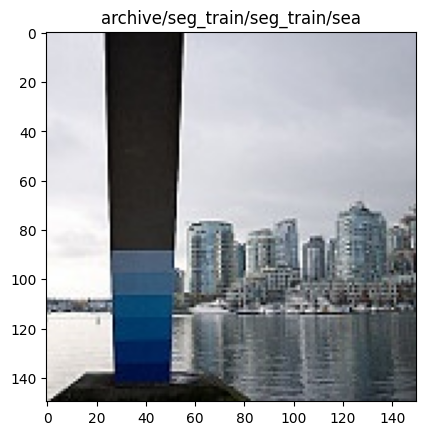

In [32]:
# make a list of images
image_list = list(train_dir.glob('*/*.jpg'))

image_path = random.choice(image_list)

# open the imahe
image = Image.open(image_path)

# plot the image
plt.imshow(image)
plt.title(image_path.parent)



### I can observe that the image is of shape 150 X 150. 

For a vision transformer the data needs to be in the shape of 224 X 224. I will transform it accordingly

In [33]:
manual_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [34]:
# Load the dataset
train_dataset_manual = datasets.ImageFolder(root=train_dir, transform=manual_transform)
test_dataset_manual = datasets.ImageFolder(root=test_dir, transform=manual_transform)

In [35]:
# Create a dataloader
train_dataloader_manual = DataLoader(dataset=train_dataset_manual, batch_size=32, shuffle=True, num_workers=1)
test_dataloader_manual = DataLoader(dataset=test_dataset_manual, batch_size=32, shuffle=True, num_workers=1)

In [36]:
# find the class names
class_names = train_dataset_manual.classes
classes_to_idx = train_dataset_manual.class_to_idx
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Text(0.5, 1.0, 'sea')

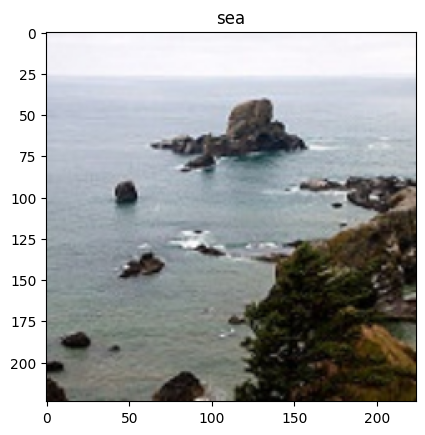

In [38]:
# Visualise an image from dataloader

image_batch, labels_batch = next(iter(train_dataloader_manual))

image,label = image_batch[0], labels_batch[0]

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])

### The data is loaded properly. Also I can see that the image size is 224 X 224

#### Steps to Build Vision Transformer

The equations that form the base of Vit architecture are as follows:
<img src="/Users/Akhil/VSCode/Pytorch-Vision-Transformer/Vit Architecture equations.png" alt="Alt Text">

In all equations "z" is the raw output of a particular layer.
1. z0 is the output of the initial patch embedding layer
2. zl' is output of an intermediate layer
3. zl is the ouput of a particular layer 

To further understand each equation:
1. <u>**In equations1:**</u> Make the image into patchs and them convert these into position embedding.<br/>
In vector form, the embedding might look something like:
<ul>
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
Where each of the elements in the vector is learnable (their requires_grad=True).
</ul>

2. <u>**In equation 2:**</u> There is a multi head self attention layer wrapping a layer norm . <br/>
There is a skil connection in the end which means additng the inout of some layers to the output of layers. This allows the model to remember both global and local information. Also helps in mitigation the vanishing gradient problem
<ul>x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input </ul>
<ul>Imagine there is a picture, and we want to understand what's happening in different parts of that picture. To do that, we divide the picture into smaller pieces called patches. Each patch is like a mini-picture that the model will analyze.

Equation 2 tells us how to calculate the value of each patch. It says that the value of a patch is determined by a combination of the values of all the patches in the image. This means that each patch looks at the values of all the other patches to figure out its own value.

To do this, the model uses something called "self-attention." Self-attention is like having a conversation between patches. Each patch listens to what the other patches have to say and decides how much it should pay attention to each one. It does this by giving each patch a score, which represents how important that patch is for understanding the current patch.

Once each patch has a score for all the other patches, it multiplies each score by the value of the corresponding patch. Then it adds up all these multiplied values to get the final value of the patch.

So, Equation 2 is like a recipe that tells the model how to calculate the value of each patch by having them talk to each other and combining their information. This helps the model understand different parts of the image and make sense of what it sees.</ul>

3. <u>**In equation 3:**</u> This says that for every layer from through to (the total number of layers), there's also a Multilayer Perceptron layer (MLP) wrapping a LayerNorm layer (LN).
<ul>
The addition on the end is showing the presence of a skip/residual connection.

We'll call this layer the "MLP block".

In pseudocode, this might look like:

x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
Notice the skip connection on the end (adding the input of the layers to the output of the layers).</ul>
<ul>Equation 3 is all about updating the values of the patches based on the calculated scores from Equation 2. It tells us how each patch should adjust its value to incorporate information from other patches.</ul>

4. <u>**In equation 4:**</u> This is the last layer and a layer norm is wrapper around the output.
<ul> y = Linear_layer(LN_layer(x_output_MLP_block[0]))</ul>
<ul>the updated patch values are transformed to produce the output of the model. This equation allows the model to make predictions or decisions based on the processed information.

Once each patch has been updated using Equation 3, the model needs to combine all the patch values into a single representation that captures the overall understanding of the image.

Equation 4 tells us how to transform the updated patch values. It involves multiplying the patch values by a set of learnable parameters called weights and adding a bias term. This process is similar to multiplying and adding numbers together to get a result.

The weights and bias terms are learned during the training of the model. They are adjusted to find the best combination that helps the model make accurate predictions based on the processed patch values.

To summarize, Equation 4 takes the updated values of the patches, applies learnable weights and a bias term, and combines them to generate the output of the vision transformer. It transforms the patch values into a compact representation that captures the essential information for decision-making.

</ul>

# 2. Equation 1: split data into patches and add position embeddings

In [41]:
height = 224
width = 224
color_channels = 3
patch_size = 16
image_size = 224

number_of_patches = int((height*width)/(patch_size*patch_size))

print("The number of patches are ",number_of_patches)

The number of patches are  196


In [42]:

image_permuted = image.permute(1,2,0)

# let me now do it for the entire image
fig, axs = plt.subplots(nrows=image_size // patch_size, ncols= image_size // patch_size, figsize = (image_size,image_size), sharex=True, sharey=True)


for i, patch_height in enumerate(range(0, image_size, patch_size)):
    for j, patch_width in enumerate(range(0, image_size, patch_size)):

        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, patch_width:patch_width+patch_size, :])

        axs[i,j].set_ylabel(i+1, 
                             rotation="horizontal", 
                             horizontalalignment="right", 
                             verticalalignment="center") 
        axs[i, j].set_xlabel(j+1) 
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i,j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [43]:
class PatchEmbedding(torch.nn.Module):
    def __init__(self,in_channels:int=3, embedding_dim:int=768, patch_size:int=16) :
        super().__init__()

        # create a convolution layer to turn image into patches
        self.patcher = torch.nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size, padding=0)

         # create a layer to flatten the patch
        self.flatten = torch.nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # perform the forward pass
        x = self.patcher(x)

        x = self.flatten(x)

        return x.permute(0, 2, 1)

In [44]:
patchify = PatchEmbedding(in_channels=3, embedding_dim=768, patch_size=16)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


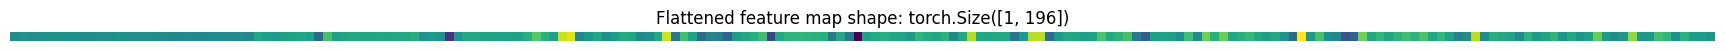

In [47]:
# Get a single flattened feature map
single_flattened_feature_map = patch_embedded_image[:, :, 0] #

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);


## Class embedding
prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension (D) and then add it to the number_of_patches dimension.

#### Psudo code:
patch_embedding = [image_patch_1, image_patch_2,...] <br/>
class_token = learnable embedding <br/>
patch_embedding_with_class_token = torch.cat((class_toke, patch_embedding), dim=1)


In [50]:
batch_size = patch_embedded_image.shape[0]
embeddim_dimension_shape = patch_embedded_image.shape[-1]

class_token = torch.nn.Parameter(torch.rand(batch_size, 1, embeddim_dimension_shape), requires_grad = True)

In [51]:
# concat the class token to the start of patches
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), dim=1)

print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")


Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## Create Position Embedding

In [52]:
# calculate number of patches
number_of_patches = int((height*width) / patch_size**2)

# get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]


position_embedding = torch.nn.Parameter(torch.rand(batch_size, number_of_patches+1, embedding_dimension), requires_grad=True)

print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [53]:
# now add the position embedding to the class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding

print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 0.9993,  1.4193,  0.3600,  ...,  1.4492,  0.9758,  0.8184],
         [ 0.8366,  1.1434,  0.4311,  ...,  0.9503,  0.5399, -0.4758],
         [ 0.3931,  0.5371, -0.0870,  ...,  0.5156,  0.8001, -0.3319],
         ...,
         [ 0.2967,  0.7179,  0.6444,  ...,  1.0197,  0.1756,  0.2820],
         [ 0.7226,  0.7934,  0.5382,  ...,  0.4930,  0.8229,  0.7800],
         [ 0.1279,  0.3048,  0.1957,  ...,  0.6378,  0.7779, -0.1758]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]
